In [1]:
import pandas as pd
import numpy as np
from math import ceil

# plotting
import matplotlib.pyplot as plt
#import seaborn as sns

# handling trajectory and other geo-data
import geopandas as gpd
import movingpandas as mpd
from shapely.geometry import Point, LineString, Polygon
from shapely import wkt
from shapely.wkt import loads



In [2]:
points = pd.read_pickle("Data/points.pkl")
# display(points_df.head())
trajs_df = pd.read_pickle("Data/trajectories.pkl")
display(trajs_df.head())

,start_time,stop_time,duration,data_points,distance,speed,line
sid,,,,,,,
2371077,2019-12-01 20:57:10+01:00,2019-12-01 20:57:20+01:00,10,3,15,5.400000,LINESTRING(314767.79803646065 6403136.59248534...
1058771,2019-11-14 16:29:26+01:00,2019-11-14 16:39:34+01:00,608,3,390,2.309211,LINESTRING(319284.49598703685 6400597.24615486...
9740192,2019-07-28 19:17:56+02:00,2019-07-28 19:18:00+02:00,4,2,8,7.200000,"LINESTRING(318385.7626873298 6398497.78847383,..."
1343036,2019-10-15 12:01:40+02:00,2019-10-15 12:02:31+02:00,51,10,268,18.917647,LINESTRING(318322.50756410987 6398287.99863713...
298787,2019-09-04 06:42:10+02:00,2019-09-04 06:42:13+02:00,3,2,4,4.800000,LINESTRING(322172.10875479446 6399075.79506390...


In [3]:
# points = points[:20000]
points['segment_distance'] = np.nan
points['segment_duration'] = np.nan
points

,x,y,timestamp,trajectory_sid,segment_distance,segment_duration
0,323606.274611,6.408043e+06,2019-09-02 10:13:10+02:00,9864759,NaN,NaN
1,323558.422427,6.408012e+06,2019-09-02 10:13:25+02:00,9864759,NaN,NaN
2,323558.834768,6.408013e+06,2019-09-02 15:57:22+02:00,54,NaN,NaN
3,323524.849684,6.408025e+06,2019-09-02 15:57:27+02:00,54,NaN,NaN
4,323559.455316,6.408011e+06,2019-09-02 16:30:57+02:00,55,NaN,NaN
...,...,...,...,...,...,...
13438326,321774.871021,6.409367e+06,2019-12-18 09:29:55+01:00,1790082,NaN,NaN
13438327,322598.491702,6.391262e+06,2019-12-31 22:34:06+01:00,1790699,NaN,NaN
13438328,307774.450960,6.393742e+06,2019-12-31 23:46:08+01:00,1791234,NaN,NaN
13438329,327900.608974,6.402742e+06,2019-12-23 19:32:18+01:00,1791850,NaN,NaN


In [4]:


def compute_distance(row):
    if row.name == 0 or row['trajectory_sid'] != row['prev_trajectory_sid']:
        return 0
    t1 = (row['prev_x'], row['prev_y'])
    t2 = (row['x'], row['y'])
    return Point(t1).distance(Point(t2))

# Before using, you need to create previous value columns
points['prev_x'] = points['x'].shift(1)
points['prev_y'] = points['y'].shift(1)
points['prev_trajectory_sid'] = points['trajectory_sid'].shift(1)

points['segment_distance'] = points.apply(compute_distance, axis=1)

# Cleanup
points.drop(columns=['prev_x', 'prev_y', 'prev_trajectory_sid'], inplace=True)




In [5]:
def compute_time_diff(row):
    if row.name == 0 or row['trajectory_sid'] != row['prev_trajectory_sid']:
        return np.nan
    time_diff = row['timestamp'] - row['prev_timestamp']
    return time_diff.total_seconds()

# Before using, you need to create previous value columns
points['prev_timestamp'] = points['timestamp'].shift(1)
points['prev_trajectory_sid'] = points['trajectory_sid'].shift(1)

points['segment_duration'] = points.apply(compute_time_diff, axis=1)

# Cleanup
points.drop(columns=['prev_timestamp', 'prev_trajectory_sid'], inplace=True)


In [6]:
points.head()

,x,y,timestamp,trajectory_sid,segment_distance,segment_duration
0,323606.274611,6.408043e+06,2019-09-02 10:13:10+02:00,9864759,0.000000,NaN
1,323558.422427,6.408012e+06,2019-09-02 10:13:25+02:00,9864759,56.876958,15.0
2,323558.834768,6.408013e+06,2019-09-02 15:57:22+02:00,54,0.000000,NaN
3,323524.849684,6.408025e+06,2019-09-02 15:57:27+02:00,54,35.814672,5.0
4,323559.455316,6.408011e+06,2019-09-02 16:30:57+02:00,55,0.000000,NaN


In [7]:
# for i in range(len(points)):
#     if i == 0:
#         #first_20_rows.iloc[0]['segment_distance'] = 0
#         points.iat[0, 4] = 0
#         #print("First row segment d: ", first_20_rows.iloc[0]['segment_distance'])
#     else:
#         try:
#             if points.iloc[i-1]['trajectory_sid'] != points.iloc[i]['trajectory_sid']:
#                 #first_20_rows.iloc[i]['segment_distance'] = 0
#                 points.iat[i, 4] = 0
#                 #print("New row with new ID segment d: ", first_20_rows.iloc[i]['segment_distance'])

#             if points.iloc[i-1]['trajectory_sid'] == points.iloc[i]['trajectory_sid']:
#                 t1 = (points.iloc[i-1]['x'], points.iloc[i-1]['y'])
#                 t2 = (points.iloc[i]['x'], points.iloc[i]['y'])
#                 d = Point(t1).distance(Point(t2))
#                 #first_20_rows.iloc[i]['segment_distance'] = d
#                 points.iat[i, 4] = d
#                 #print("segment d: ", first_20_rows.iloc[i]['segment_distance'])

#             else:
#                 pass
            
#         except:
#             pass

In [8]:
# for i in range(len(points)):
#     if i == 0:
#         points.iat[i, 5] = np.nan

#     else:
#         try:
#             if points.iloc[i-1]['trajectory_sid'] != points.iloc[i]['trajectory_sid']:
#                 points.iat[i, 5] = np.nan
#                 #first_20_rows.iat[i, 5] = first_20_rows.iloc[i]['segment_duration'].total_seconds()

#             if points.iloc[i-1]['trajectory_sid'] == points.iloc[i]['trajectory_sid']:
#                 time1 = points.iloc[i-1]['timestamp']
#                 time2 = points.iloc[i]['timestamp']
#                 d_time = time2 - time1
#                 points.iat[i, 5] = d_time
#                 points.iat[i, 5] = points.iloc[i]['segment_duration'].total_seconds()

#             else:
#                 pass
            
#         except:
#             pass



In [9]:
points['segment_velocity (m/s)'] = 0
points

,x,y,timestamp,trajectory_sid,segment_distance,segment_duration,segment_velocity (m/s)
0,323606.274611,6.408043e+06,2019-09-02 10:13:10+02:00,9864759,0.000000,NaN,0
1,323558.422427,6.408012e+06,2019-09-02 10:13:25+02:00,9864759,56.876958,15.0,0
2,323558.834768,6.408013e+06,2019-09-02 15:57:22+02:00,54,0.000000,NaN,0
3,323524.849684,6.408025e+06,2019-09-02 15:57:27+02:00,54,35.814672,5.0,0
4,323559.455316,6.408011e+06,2019-09-02 16:30:57+02:00,55,0.000000,NaN,0
...,...,...,...,...,...,...,...
13438326,321774.871021,6.409367e+06,2019-12-18 09:29:55+01:00,1790082,0.000000,NaN,0
13438327,322598.491702,6.391262e+06,2019-12-31 22:34:06+01:00,1790699,0.000000,NaN,0
13438328,307774.450960,6.393742e+06,2019-12-31 23:46:08+01:00,1791234,0.000000,NaN,0
13438329,327900.608974,6.402742e+06,2019-12-23 19:32:18+01:00,1791850,0.000000,NaN,0


In [10]:
points['segment_velocity (m/s)'] = np.where(
    points['segment_duration'] != 0,
    points['segment_distance'] / points['segment_duration'],
    0
)

In [11]:
points['segment_velocity (km/h)'] = points['segment_velocity (m/s)'] * 3.6
points

,x,y,timestamp,trajectory_sid,segment_distance,segment_duration,segment_velocity (m/s),segment_velocity (km/h)
0,323606.274611,6.408043e+06,2019-09-02 10:13:10+02:00,9864759,0.000000,NaN,NaN,NaN
1,323558.422427,6.408012e+06,2019-09-02 10:13:25+02:00,9864759,56.876958,15.0,3.791797,13.650470
2,323558.834768,6.408013e+06,2019-09-02 15:57:22+02:00,54,0.000000,NaN,NaN,NaN
3,323524.849684,6.408025e+06,2019-09-02 15:57:27+02:00,54,35.814672,5.0,7.162934,25.786564
4,323559.455316,6.408011e+06,2019-09-02 16:30:57+02:00,55,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
13438326,321774.871021,6.409367e+06,2019-12-18 09:29:55+01:00,1790082,0.000000,NaN,NaN,NaN
13438327,322598.491702,6.391262e+06,2019-12-31 22:34:06+01:00,1790699,0.000000,NaN,NaN,NaN
13438328,307774.450960,6.393742e+06,2019-12-31 23:46:08+01:00,1791234,0.000000,NaN,NaN,NaN
13438329,327900.608974,6.402742e+06,2019-12-23 19:32:18+01:00,1791850,0.000000,NaN,NaN,NaN


In [12]:
# points['segment acceleration (m/s^2)'] = 0
# points

In [13]:
# def compute_acceleration(row):
#     if row.name == 0:
#         return 0

#     if row['trajectory_sid'] != row['prev_trajectory_sid']:
#         row['counter'] = 1
#         return np.nan

#     if row['segment_duration'] == 0:  # Add this condition
#         return 0

#     if row['counter'] == 1:
#         vel1 = 0
#         vel2 = row['segment_velocity (m/s)']
#         d_vel = vel2 - vel1
#         row['counter'] += 1
#         return d_vel / row['segment_duration']

#     if row['counter'] > 1:
#         vel1 = row['prev_velocity']
#         vel2 = row['segment_velocity (m/s)']
#         d_vel = vel2 - vel1
#         row['counter'] += 1
#         return d_vel / row['segment_duration']

#     return np.nan

# # Before using, you need to create previous value columns
# points['prev_trajectory_sid'] = points['trajectory_sid'].shift(1)
# points['prev_velocity'] = points['segment_velocity (m/s)'].shift(1)
# points['counter'] = points.groupby('trajectory_sid').cumcount() + 1

# points['acceleration'] = points.apply(compute_acceleration, axis=1)

# # Cleanup
# points.drop(columns=['prev_trajectory_sid', 'prev_velocity', 'counter'], inplace=True)

In [14]:
points.head()

,x,y,timestamp,trajectory_sid,segment_distance,segment_duration,segment_velocity (m/s),segment_velocity (km/h)
0,323606.274611,6.408043e+06,2019-09-02 10:13:10+02:00,9864759,0.000000,NaN,NaN,NaN
1,323558.422427,6.408012e+06,2019-09-02 10:13:25+02:00,9864759,56.876958,15.0,3.791797,13.650470
2,323558.834768,6.408013e+06,2019-09-02 15:57:22+02:00,54,0.000000,NaN,NaN,NaN
3,323524.849684,6.408025e+06,2019-09-02 15:57:27+02:00,54,35.814672,5.0,7.162934,25.786564
4,323559.455316,6.408011e+06,2019-09-02 16:30:57+02:00,55,0.000000,NaN,NaN,NaN


In [15]:
# c = 0
# for i in range(len(points)):
#     if i == 0:
#         points.iat[i, 8] = 0
#         c+=1

#     else:
#         try:
#             if points.iloc[i-1]['trajectory_sid'] != points.iloc[i]['trajectory_sid']:
#                 points.iat[i, 8] = np.nan
#                 c=1
            
#             if (points.iloc[i-1]['trajectory_sid'] == points.iloc[i]['trajectory_sid'] and c==1):
#                 vel1 = 0
#                 vel2 = points.iloc[i]['segment_velocity (m/s)']
#                 d_vel = vel2 - vel1
#                 points.iat[i, 8] = d_vel / points.iloc[i]['segment_duration']
#                 c+=1
#                 continue

#             if (points.iloc[i-1]['trajectory_sid'] == points.iloc[i]['trajectory_sid'] and c>1):
#                 vel1 = points.iloc[i-1]['segment_velocity (m/s)']
#                 vel2 = points.iloc[i]['segment_velocity (m/s)']
#                 d_vel = vel2 - vel1
#                 points.iat[i, 8] = d_vel / points.iloc[i]['segment_duration']
#                 c+=1

#             else:
#                 pass
            
#         except:
#             pass

In [16]:
vel_means = pd.DataFrame()
grouped_20_rows = points.groupby('trajectory_sid')
vel_means['mean_velocity'] = grouped_20_rows['segment_velocity (km/h)'].mean()
vel_means['Number of data points'] = grouped_20_rows['trajectory_sid'].count()
vel_means['duration'] = grouped_20_rows['segment_duration'].sum()
vel_means = vel_means.drop(vel_means[vel_means['duration'] == 0].index)
vel_means['total_distance'] = grouped_20_rows['segment_distance'].sum()
vel_means['duration/frequency'] = vel_means['duration'] / vel_means['Number of data points']
vel_means['frequency/duration'] = vel_means['Number of data points'] / vel_means['duration']
vel_means = vel_means.dropna()
vel_means.head()

,mean_velocity,Number of data points,duration,total_distance,duration/frequency,frequency/duration
trajectory_sid,,,,,,
1,95.627061,56,275.0,7304.844915,4.910714,0.203636
3,95.396003,35,170.0,4504.811231,4.857143,0.205882
4,82.651597,139,710.0,16329.491799,5.107914,0.195775
7,87.946525,83,420.0,10044.958281,5.060241,0.197619
11,88.442302,126,708.0,17367.557538,5.619048,0.177966


In [17]:
#vel_means['frequency/duration'].max()
vel_means[vel_means['frequency/duration'] == vel_means['frequency/duration'].max()].iloc[0]

mean_velocity              -35.178007
Number of data points      315.000000
duration                     5.000000
total_distance           80233.631827
duration/frequency           0.015873
frequency/duration          63.000000
Name: 8441635, dtype: float64

In [18]:
over_120 = vel_means[vel_means['mean_velocity'] > 120]
under_120 = vel_means[vel_means['mean_velocity'] <= 120]
max_duration_frequency = over_120['duration/frequency'].max()
result = over_120[over_120['duration/frequency'] == max_duration_frequency]

print(over_120['duration/frequency'].mean())
print(over_120['duration/frequency'].std())
print(under_120['duration/frequency'].mean())
print(under_120['duration/frequency'].std())
print(over_120['frequency/duration'].mean())
print(over_120['frequency/duration'].std())
print(under_120['frequency/duration'].mean())
print(under_120['frequency/duration'].std())

15.886241729114571
59.03507867855515
92.65359296671826
247.6204202386109
0.23899906563104056
0.2535943852675301
0.1850303962390755
0.37080947955600113


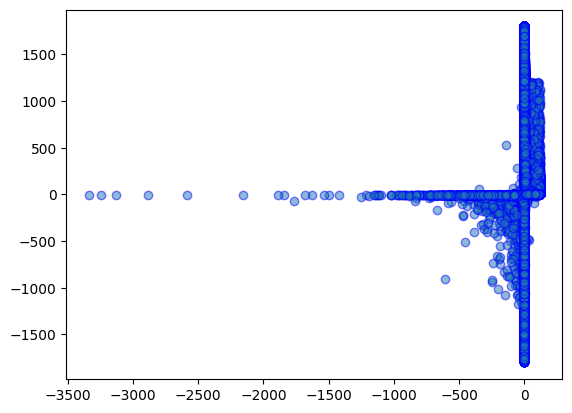

In [19]:
plt.scatter(y=under_120['duration/frequency'], x=under_120['mean_velocity'], alpha=0.5, edgecolors='b')
plt.show()

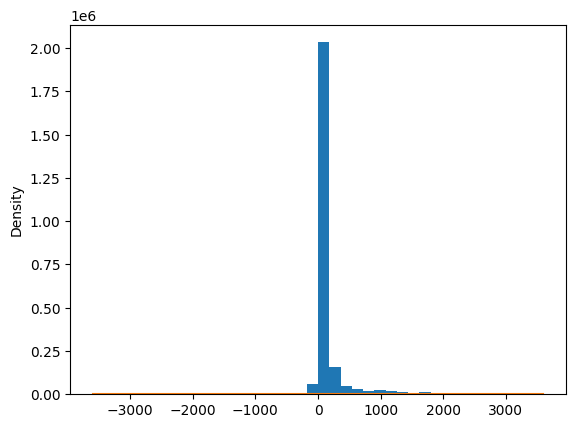

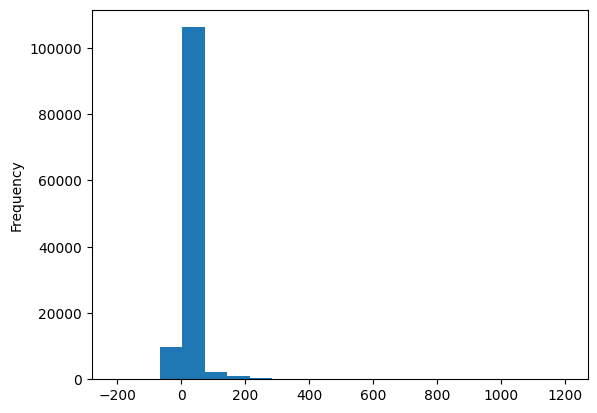

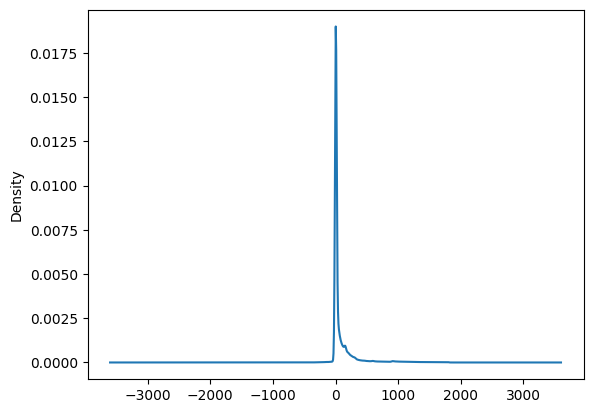

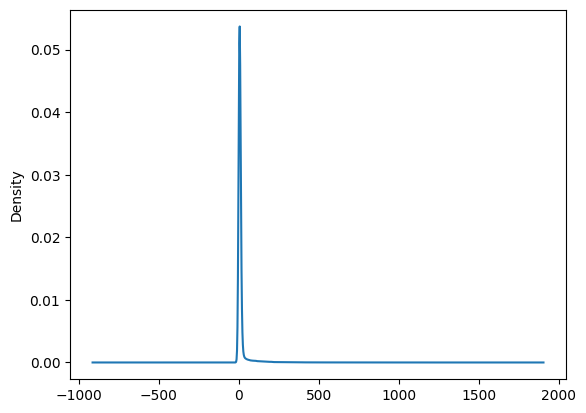

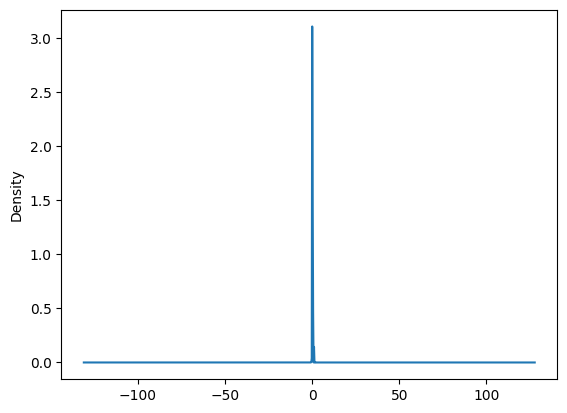

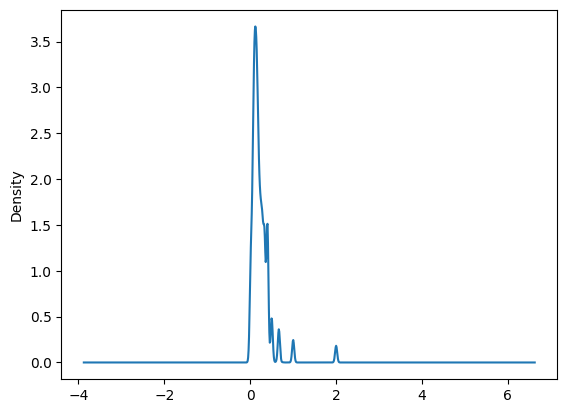

Data does not appear to be normally distributed
Data does not appear to be normally distributed


c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [20]:
from scipy import stats

under_120['duration/frequency'].plot(kind='hist', bins=20)
under_120['duration/frequency'].plot(kind='kde')
plt.show()

over_120['duration/frequency'].plot(kind='hist', bins=20)
plt.show()

under_120['duration/frequency'].plot(kind='kde')
plt.show()

over_120['duration/frequency'].plot(kind='kde')
plt.show()

under_120['frequency/duration'].plot(kind='kde')
plt.show()

over_120['frequency/duration'].plot(kind='kde')
plt.show()

stat, p = stats.shapiro(under_120['frequency/duration'])

if p > 0.05:
    print("Data appears to be normally distributed")
else:
    print("Data does not appear to be normally distributed")

stat, p = stats.shapiro(over_120['frequency/duration'])

if p > 0.05:
    print("Data appears to be normally distributed")
else:
    print("Data does not appear to be normally distributed")

In [21]:
print(len(under_120), len(over_120))

2422564 120365


C:\Users\Timze\AppData\Local\Temp\ipykernel_21136\4060180392.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(under_120['frequency/duration'],


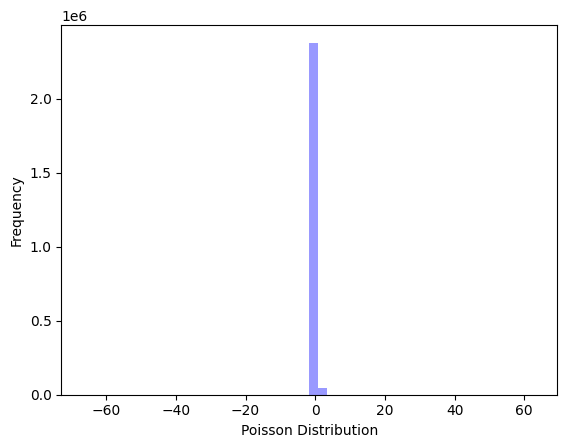

C:\Users\Timze\AppData\Local\Temp\ipykernel_21136\4060180392.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(over_120['frequency/duration'],


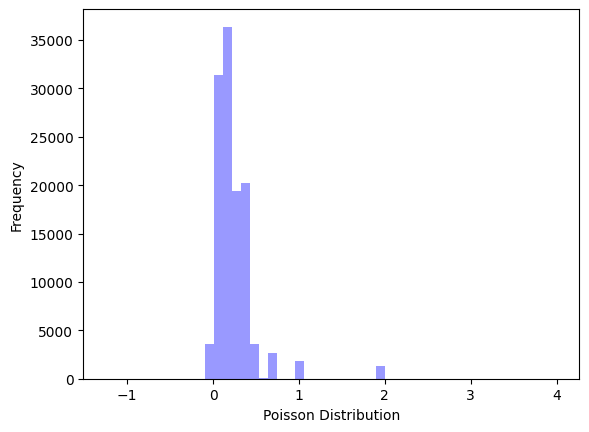

In [22]:
import seaborn as sns

ax = sns.distplot(under_120['frequency/duration'],
                  kde=False,
                  color='blue')
ax.set(xlabel='Poisson Distribution', ylabel='Frequency')
 
plt.show()

ax = sns.distplot(over_120['frequency/duration'],
                  kde=False,
                  color='blue')
ax.set(xlabel='Poisson Distribution', ylabel='Frequency')
 
plt.show()

In [23]:
from scipy.stats import chi2_contingency

data = {'Category A': under_120['frequency/duration'], 'Category B': over_120['frequency/duration']}
contingency_table = pd.DataFrame(data)

chi2, p, dof, expected = chi2_contingency(contingency_table)

if p < 0.0001:
    print("There is a significant association between Category A and Category B.")
else:
    print("There is no significant association between Category A and Category B.")

ValueError: All values in `observed` must be nonnegative.

In [24]:
from scipy import stats
import numpy as np

under_120['duration/frequency'] = under_120['duration/frequency'].astype(float)
over_120['duration/frequency'] = over_120['duration/frequency'].astype(float)

print(under_120['duration/frequency'].mean())
print(over_120['duration/frequency'].mean())

# Perform the paired t-test
t_statistic, p_value = stats.ttest_ind(under_120['duration/frequency'], over_120['duration/frequency'])

# Analyze the results
alpha = 0.05  # Significance level
if p_value < alpha:
    print("The paired t-test results are statistically significant.")
else:
    print("The paired t-test results are not statistically significant.")

# Print the t-statistic and p-value
print(f"t-statistic: {t_statistic}")
print(f"p-value: {p_value}")


92.65359296671826
15.886241729114571
The paired t-test results are statistically significant.
t-statistic: 107.40580715899496
p-value: 0.0


C:\Users\Timze\AppData\Local\Temp\ipykernel_21136\750838754.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  under_120['duration/frequency'] = under_120['duration/frequency'].astype(float)
C:\Users\Timze\AppData\Local\Temp\ipykernel_21136\750838754.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  over_120['duration/frequency'] = over_120['duration/frequency'].astype(float)


In [25]:
grouped_20_rows.head()

,x,y,timestamp,trajectory_sid,segment_distance,segment_duration,segment_velocity (m/s),segment_velocity (km/h)
0,323606.274611,6.408043e+06,2019-09-02 10:13:10+02:00,9864759,0.000000,NaN,NaN,NaN
1,323558.422427,6.408012e+06,2019-09-02 10:13:25+02:00,9864759,56.876958,15.0,3.791797,13.650470
2,323558.834768,6.408013e+06,2019-09-02 15:57:22+02:00,54,0.000000,NaN,NaN,NaN
3,323524.849684,6.408025e+06,2019-09-02 15:57:27+02:00,54,35.814672,5.0,7.162934,25.786564
4,323559.455316,6.408011e+06,2019-09-02 16:30:57+02:00,55,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
13438326,321774.871021,6.409367e+06,2019-12-18 09:29:55+01:00,1790082,0.000000,NaN,NaN,NaN
13438327,322598.491702,6.391262e+06,2019-12-31 22:34:06+01:00,1790699,0.000000,NaN,NaN,NaN
13438328,307774.450960,6.393742e+06,2019-12-31 23:46:08+01:00,1791234,0.000000,NaN,NaN,NaN
13438329,327900.608974,6.402742e+06,2019-12-23 19:32:18+01:00,1791850,0.000000,NaN,NaN,NaN


In [26]:
vel_means[vel_means['mean_velocity'] >= 110]

,mean_velocity,Number of data points,duration,total_distance,duration/frequency,frequency/duration
trajectory_sid,,,,,,
76,279.681718,2,5.0,388.446831,2.500000,0.400000
82,206.590569,2,6.0,344.317614,3.000000,0.333333
1146,198.468020,3,31.0,1664.570491,10.333333,0.096774
1147,172.847754,6,119.0,4161.426228,19.833333,0.050420
1148,230.478991,2,13.0,832.285246,6.500000,0.153846
...,...,...,...,...,...,...
9864035,114.282704,50,245.0,7775.602300,4.900000,0.204082
9864477,113.403710,21,160.0,5078.366672,7.619048,0.131250
9864648,131.218007,50,245.0,8940.426245,4.900000,0.204082


In [27]:
points.head()

,x,y,timestamp,trajectory_sid,segment_distance,segment_duration,segment_velocity (m/s),segment_velocity (km/h)
0,323606.274611,6.408043e+06,2019-09-02 10:13:10+02:00,9864759,0.000000,NaN,NaN,NaN
1,323558.422427,6.408012e+06,2019-09-02 10:13:25+02:00,9864759,56.876958,15.0,3.791797,13.650470
2,323558.834768,6.408013e+06,2019-09-02 15:57:22+02:00,54,0.000000,NaN,NaN,NaN
3,323524.849684,6.408025e+06,2019-09-02 15:57:27+02:00,54,35.814672,5.0,7.162934,25.786564
4,323559.455316,6.408011e+06,2019-09-02 16:30:57+02:00,55,0.000000,NaN,NaN,NaN


Tims Kod

In [ ]:
# points = points.sort_values(by=["trajectory_sid", "timestamp"])
# grouped_points = points.groupby("trajectory_sid")["timestamp"].agg(list).reset_index()

# heading_df = pd.merge(trajs_df, grouped_points, left_index=True, right_on="trajectory_sid", how="left")

# road_80_points = [LineString([(322169, 6411344), (322081, 6412907)]), LineString([(322108, 6408320), (322143, 6408455)]), LineString([(323509, 6402118), (323445, 6402093)]), LineString([(321349, 6397697), (321290, 6397846)]), LineString([(322376, 6396936), (322191, 6397229)])]
# road_80_names = ["angered", "agnesberg", "torpamotet", "kallebäck", "riksväg_40"]


In [28]:
points = points.sort_values(by=["trajectory_sid", "timestamp"])

# Grouping to get a list of timestamps
grouped_timestamps = points.groupby("trajectory_sid")["timestamp"].apply(list).reset_index()
grouped_timestamps.columns = ["trajectory_sid", "timestamp_list"]

# Merging original points with the timestamp lists
combined_points = pd.merge(points, grouped_timestamps, on="trajectory_sid", how="left")

# Dropping duplicates to get one row per "trajectory_sid"
combined_points = combined_points.drop_duplicates(subset="trajectory_sid", keep='first')

# Merging with trajs_df
heading_df = pd.merge(trajs_df, combined_points, left_index=True, right_on="trajectory_sid", how="left")



In [29]:
road_80_points = [LineString([(322169, 6411344), (322081, 6412907)]), LineString([(322108, 6408320), (322143, 6408455)]), LineString([(323509, 6402118), (323445, 6402093)]), LineString([(321349, 6397697), (321290, 6397846)]), LineString([(322376, 6396936), (322191, 6397229)])]
road_80_names = ["angered", "agnesberg", "torpamotet", "kallebäck", "riksväg_40"]


In [ ]:
# from shapely import to_geojson, from_geojson

# buffer_distance = 20

# buffered_road_sections = []
# for road_name in road_80_names:
#     with open(f'geometries/{road_name}.geojson', 'r') as f:
#         buffered_road_sections.append(from_geojson(f.read()))

In [ ]:
# heading_df.line = heading_df.line.apply(loads)

In [ ]:
# for idx, section_name in enumerate(road_80_names):
#     # Create a buffered polygon around the road section
#     buffered_road_section = buffered_road_sections[idx]
#     # make a column with True if trajectory intersects buffered road section, else False
#     heading_df[section_name] = heading_df.line.apply(lambda x: x.intersects(buffered_road_section))
#     print(section_name, 'done.')

In [30]:


for road_section in range(len(road_80_points)):

    
    # Convert the road_section to a Shapely LineString object
    road_section_line = road_80_points[road_section]

    # Define the buffer distance (adjust as needed)
    buffer_distance = 20.0  # Adjust the buffer distance as needed (in the same units as your coordinates)

    # Create a buffered polygon around the road section
    buffered_road_section = road_80_points[road_section].buffer(buffer_distance)

    def count_cars_passing(trajectory, buffered_road_section):
        try:
            # Convert the trajectory to a Shapely LineString object
            trajectory_line = loads(trajectory)
            
            # Check if the trajectory intersects the buffered road section
            if trajectory_line.intersects(buffered_road_section):
                return 1  # This trajectory intersects the buffered road section
            else:
                return 0  # This trajectory does not intersect the buffered road section
        except:
            pass

    heading_df[road_80_names[road_section]] = heading_df['line'].apply(count_cars_passing, buffered_road_section=buffered_road_section)

In [ ]:
heading_df.columns

In [ ]:
# heading_df = heading_df[(heading_df["angered"] == 1) | (heading_df["agnesberg"] == 1) | (heading_df["torpamotet"] == 1)].reset_index(drop=True)


# heading_df['geometry'] = heading_df['line']#.apply(wkt.loads)

# # Convert DataFrame to GeoDataFrame
# geodf = gpd.GeoDataFrame(heading_df, geometry='geometry')

# def extract_coords_and_time(line, timestamps, point1, point2):
#     coords = list(line.coords)

#     distance_p1 = [Point(pt).distance(point1) for pt in coords]
#     distance_p2 = [Point(pt).distance(point2) for pt in coords]
#     # print(distance_p1)
#     # print(distance_p2)

#     closest_index_p1 = distance_p1.index(min(distance_p1))
#     closest_index_p2 = distance_p2.index(min(distance_p2))
#     # print(f"close index p1: {closest_index_p1}. Close index p2: {closest_index_p2}")
#     # print(f"distance_p1: {min(distance_p1)}. Distance p2 {min(distance_p2)}")

#     # Extract the segment between the closest points
#     filtered_coords = coords[closest_index_p1:closest_index_p2 + 1]
#     filtered_timestamps = timestamps[closest_index_p1:closest_index_p2 + 1]

#     if len(filtered_coords) < 2:
#         return None, None

#     return LineString(filtered_coords), filtered_timestamps



# distance_points = {"angered": [[Point(322169, 6411344), Point(322081, 6412907)], [(340, 360), (160, 180)]], "agnesberg": [[Point(322108, 6408320), Point(322143, 6408455)], [(10, 30), (190, 210)]], "torpamotet": [[Point(323509, 6402118), Point(323445, 6402093)], [(60, 80), (240, 260)]]}

# for road_name in road_80_names:
#     POINT1, POINT2 = distance_points[road_name][0]
#     print(POINT1, POINT2)
    
#     mask = geodf[road_name] == 1
#     print(mask)
    
#     def wrapper(row):
#         return extract_coords_and_time(row['geometry'], row['timestamp'], POINT1, POINT2)

#     filtered_data = geodf[mask].apply(wrapper, axis=1, result_type="expand")
#     print(filtered_data)

#     geodf.loc[mask, 'filtered_trajectory'] = filtered_data[0]
#     geodf.loc[mask, 'filtered_timestamps'] = filtered_data[1]


In [33]:
heading_df = heading_df[(heading_df["angered"] == 1) | (heading_df["agnesberg"] == 1) | (heading_df["torpamotet"] == 1) | (heading_df["kallebäck"] == 1) | (heading_df["riksväg_40"])].reset_index(drop=True)


heading_df['geometry'] = heading_df['line'].apply(wkt.loads)

def ensure_iterable(timestamp):
    if isinstance(timestamp, list): # or use pd.Series if that's the expected datatype
        return timestamp
    return [timestamp]

heading_df['timestamp'] = heading_df['timestamp'].apply(ensure_iterable)


# Convert DataFrame to GeoDataFrame
geodf = gpd.GeoDataFrame(heading_df, geometry='geometry')

def extract_coords_and_time(line, timestamps, point1, point2):
    coords = list(line.coords)

    distance_p1 = [Point(pt).distance(point1) for pt in coords]
    distance_p2 = [Point(pt).distance(point2) for pt in coords]
    # print(distance_p1)
    # print(distance_p2)

    closest_index_p1 = distance_p1.index(min(distance_p1))
    closest_index_p2 = distance_p2.index(min(distance_p2))
    # print(f"close index p1: {closest_index_p1}. Close index p2: {closest_index_p2}")
    # print(f"distance_p1: {min(distance_p1)}. Distance p2 {min(distance_p2)}")

    # Extract the segment between the closest points
    filtered_coords = coords[closest_index_p1:closest_index_p2 + 1]
    filtered_timestamps = timestamps[closest_index_p1:closest_index_p2 + 1]

    if len(filtered_coords) < 2:
        return None, None

    return LineString(filtered_coords), filtered_timestamps


### # kan vara fel med point1, point2 sista listan som matchar koordinaterna på dicten

distance_points = {"angered": [[Point(322169, 6411344), Point(322081, 6412907)], [(340, 360), (160, 180)]], "agnesberg": [[Point(322108, 6408320), Point(322143, 6408455)], [(10, 30), (190, 210)]], "torpamotet": [[Point(323509, 6402118), Point(323445, 6402093)], [(60, 80), (240, 260)]],
                   "kallebäck": [[Point(321349, 6397697), Point(321290, 6397846)], [(150, 170), (330, 350)]], "riksväg_40": [[Point(322376, 6396936), Point(322191, 6397229)], [(120, 160), (300, 340)]]}

for road_name in road_80_names:
    POINT1, POINT2 = distance_points[road_name][0]
    
    mask = geodf[road_name] == 1
    
    def wrapper(row):
        return extract_coords_and_time(row['geometry'], row['timestamp'], POINT1, POINT2)
    
    filtered_data = geodf[mask].apply(wrapper, axis=1, result_type="expand")
    
    geodf.loc[mask, 'filtered_trajectory'] = filtered_data[0]
    geodf.loc[mask, 'filtered_timestamps'] = filtered_data[1]


In [35]:
heading_df.head()


,start_time,stop_time,duration,data_points,distance,speed,line,x,y,timestamp,...,segment_duration,segment_velocity (m/s),segment_velocity (km/h),timestamp_list,angered,agnesberg,torpamotet,kallebäck,riksväg_40,geometry
0,2019-08-23 13:51:34+02:00,2019-08-23 13:51:43+02:00,9,2,226,90.400000,LINESTRING(321332.54744684225 6397736.20471408...,321332.547447,6.397736e+06,[2019-08-23 13:51:34+02:00],...,NaN,NaN,NaN,"[2019-08-23 13:51:34+02:00, 2019-08-23 13:51:4...",0,0,0,1,0,LINESTRING (321332.54744684225 6397736.2047140...
1,2019-12-22 11:11:02+01:00,2019-12-22 11:13:57+01:00,175,35,5244,107.876571,LINESTRING(322176.5838311423 6410451.497254174...,322176.583831,6.410451e+06,[2019-12-22 11:11:02+01:00],...,NaN,NaN,NaN,"[2019-12-22 11:11:02+01:00, 2019-12-22 11:11:0...",1,0,0,0,0,LINESTRING (322176.5838311423 6410451.49725417...
2,2019-12-04 14:05:01+01:00,2019-12-04 14:05:32+01:00,31,7,804,93.367742,LINESTRING(322118.70306073106 6411846.46730726...,322118.703061,6.411846e+06,[2019-12-04 14:05:01+01:00],...,NaN,NaN,NaN,"[2019-12-04 14:05:01+01:00, 2019-12-04 14:05:0...",1,0,0,0,0,LINESTRING (322118.70306073106 6411846.4673072...
3,2019-07-25 08:15:21+02:00,2019-07-25 08:24:27+02:00,546,107,10284,67.806593,LINESTRING(320669.7805854229 6401292.085530165...,320669.780585,6.401292e+06,[2019-07-25 08:15:21+02:00],...,NaN,NaN,NaN,"[2019-07-25 08:15:21+02:00, 2019-07-25 08:15:2...",0,0,0,0,1,LINESTRING (320669.7805854229 6401292.08553016...
4,2019-07-27 08:58:27+02:00,2019-07-27 09:27:52+02:00,1765,340,49094,100.135071,LINESTRING(321099.3599695222 6400405.682023986...,321099.359970,6.400406e+06,[2019-07-27 08:58:27+02:00],...,NaN,NaN,NaN,"[2019-07-27 08:58:27+02:00, 2019-07-27 08:58:3...",0,0,0,1,0,LINESTRING (321099.3599695222 6400405.68202398...


In [36]:
filt_geo = geodf[geodf.filtered_trajectory.notna()].reset_index(drop=True)

import math

def calculate_heading(x1, y1, x2, y2):
    delta_x = x2 - x1
    delta_y = y2 - y1
    theta_rad = math.atan2(delta_x, delta_y)
    theta_deg = math.degrees(theta_rad)
    if theta_deg < 0:
        theta_deg += 360
    return theta_deg

def get_headings(linestring):
    coords = list(linestring.coords)
    # headings = 0
    for i in range(len(coords) - 1):
        x1, y1 = coords[i]
        x2, y2 = coords[i+1]
        heading = calculate_heading(x1, y1, x2, y2)
        # headings.append(heading)
    return heading

# Sample DataFrame with LineString column

filt_geo['headings'] = filt_geo['filtered_trajectory'].apply(get_headings)

In [37]:
# Starting with an empty mask (all False values)
mask = pd.Series([False] * len(filt_geo))

for road_name in road_80_names:  # Iterate over road names
    heading_thresholds = distance_points[road_name][1]
    road_mask = (filt_geo[road_name] == 1)  # Start with a mask for the current road

    # Construct heading-based conditions for the current road
    conditions = [
        ((filt_geo['headings'] >= threshold[0]) & (filt_geo['headings'] <= threshold[1]))
        for threshold in heading_thresholds
    ]

    # Combine conditions with OR (|)
    combined_conditions = conditions[0]
    for condition in conditions[1:]:
        combined_conditions |= condition

    # Combine road mask with heading-based conditions using AND (&)
    road_mask &= combined_conditions

    # Combine with overall mask using OR (|)
    mask |= road_mask

# Filter the dataframe using the mask
heading_df = filt_geo[mask]


In [38]:
heading_df['first_timestamp'] = heading_df['timestamp'].apply(lambda x: x[0] if isinstance(x, list) and x else None)
heading_df['first_timestamp'] = heading_df['first_timestamp'].astype(str)

heading_df['first_timestamp'] = heading_df['first_timestamp'].str.replace("+02:00", "").str.replace("+01:00", "")
heading_df.first_timestamp = pd.to_datetime(heading_df['first_timestamp'])

c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is tryin

c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is tryin

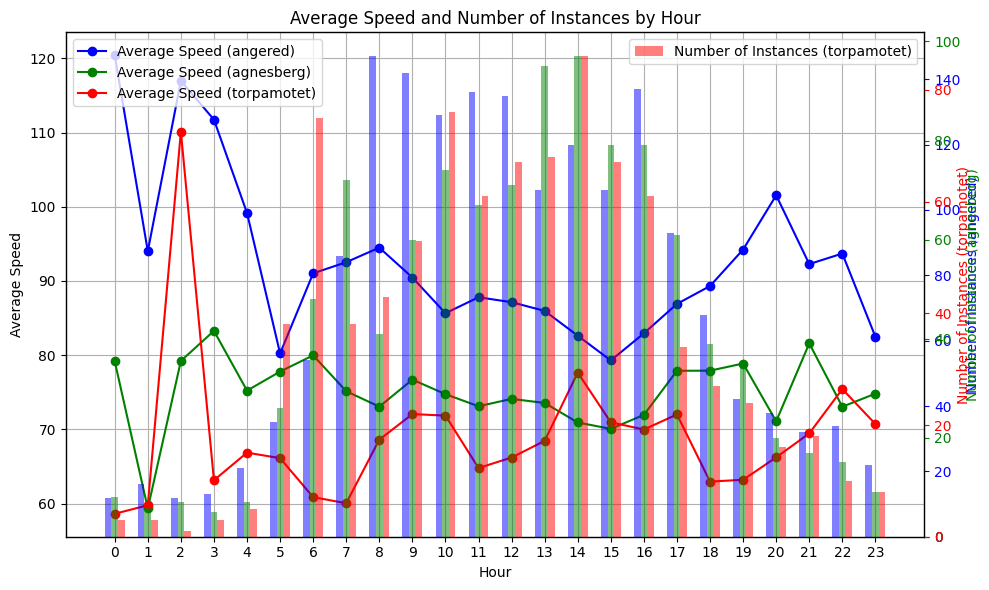

In [39]:
fig, ax1 = plt.subplots(figsize=(10, 6))

colors = ['b', 'g', 'r']  # Different colors for each road
road_80_names = ["angered", "agnesberg", "torpamotet"]  # Your road names

for idx, road_name in enumerate(road_80_names):
    # Filter rows for the current road
    road_df = heading_df[heading_df[road_name] == 1]
    
    # Compute hourly average speed and counts
    road_df['hour'] = road_df['first_timestamp'].dt.hour
    hourly_avg_speed = road_df.groupby('hour')['speed'].mean().reset_index()
    hourly_counts = road_df.groupby('hour').size().reset_index(name='count')

    hour_values = hourly_avg_speed['hour'].values
    speed_values = hourly_avg_speed['speed'].values

    # Plot average speed for the current road on the left y-axis
    ax1.plot(hour_values, speed_values, marker='o', linestyle='-', color=colors[idx], label=f'Average Speed ({road_name})')
    
    # Plot number of instances for the current road on the right y-axis
    ax2 = ax1.twinx()
    ax2.bar(hourly_counts['hour'] + 0.2*(idx-1), hourly_counts['count'], color=colors[idx], alpha=0.5, label=f'Number of Instances ({road_name})', width=0.2)
    ax2.set_ylabel(f'Number of Instances ({road_name})', color=colors[idx])
    ax2.tick_params('y', colors=colors[idx])

ax1.set_xlabel('Hour')
ax1.set_ylabel('Average Speed')
ax1.set_xticks(hourly_avg_speed['hour'])
ax1.grid(True)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Average Speed and Number of Instances by Hour')
fig.tight_layout()
plt.show()



c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


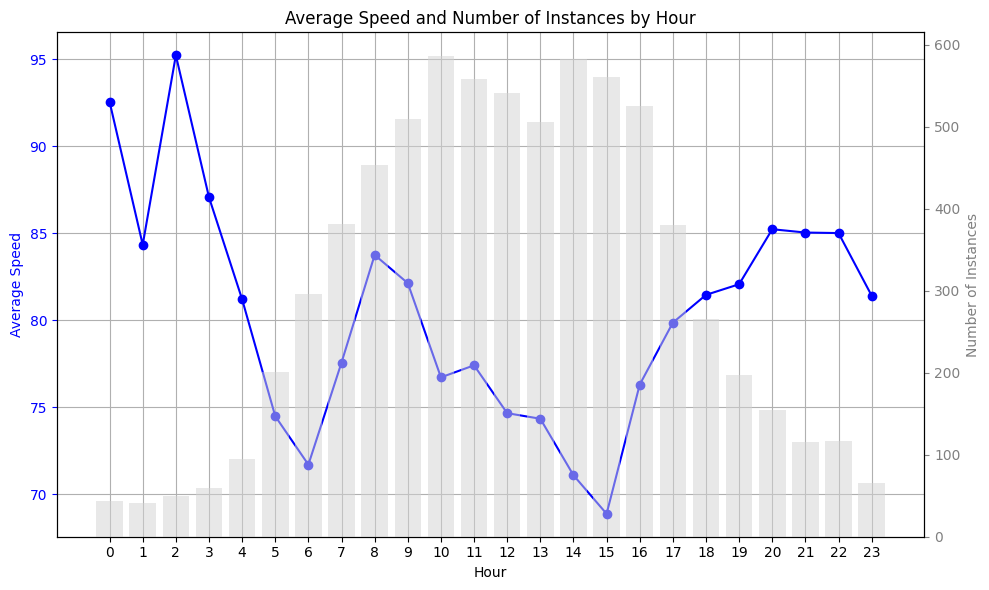

In [40]:
heading_df['hour'] = heading_df['first_timestamp'].dt.hour
hourly_avg_speed = heading_df.groupby('hour')['speed'].mean().reset_index()



hourly_counts = heading_df.groupby('hour').size().reset_index(name='count')


fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot average speed on the left y-axis
ax1.plot(hourly_avg_speed['hour'], hourly_avg_speed['speed'], marker='o', linestyle='-', color='b', label='Average Speed')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Average Speed', color='b')
ax1.tick_params('y', colors='b')
ax1.set_xticks(hourly_avg_speed['hour'])

# Create a second y-axis to plot the number of instances
ax2 = ax1.twinx()
ax2.bar(hourly_counts['hour'], hourly_counts['count'], color='lightgray', alpha=0.5, label='Number of Instances')
ax2.set_ylabel('Number of Instances', color='gray')
ax2.tick_params('y', colors='gray')

# Set title, grid and show the plot
plt.title('Average Speed and Number of Instances by Hour')
ax1.grid(True)
fig.tight_layout()
plt.show()

(array([1.000000e+00, 1.000000e+00, 4.000000e+00, 3.000000e+00,
        3.000000e+00, 5.000000e+00, 4.000000e+00, 0.000000e+00,
        5.000000e+00, 7.000000e+00, 3.000000e+00, 0.000000e+00,
        4.000000e+00, 2.000000e+00, 0.000000e+00, 1.000000e+00,
        2.000000e+00, 0.000000e+00, 1.000000e+00, 2.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00,
        0.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00,
        0.000000e+00, 1.000000e+00, 0.000000e+00, 2.000000e+00,
        2.000000e+00, 1.000000e+00, 2.000000e+00, 1.000000e+00,
        5.000000e+00, 1.000000e+00, 2.000000e+00, 2.000000e+00,
        2.000000e+00, 2.000000e+00, 3.000000e+00, 1.000000e+00,
        3.000000e+00, 5.000000e+00, 2.000000e+00, 1.000000e+01,
        2.400000e+01, 5.220000e+02, 4.537000e+03, 2.373597e+06,
        4.370000e+04, 3.600000e+01, 1.500000e+01, 7.000000e+00,
        5.000000e+00, 1.000000e+00, 2.000000e+00, 2.000000e+00,
        3.000000e+00, 0.000000e+00, 0.00

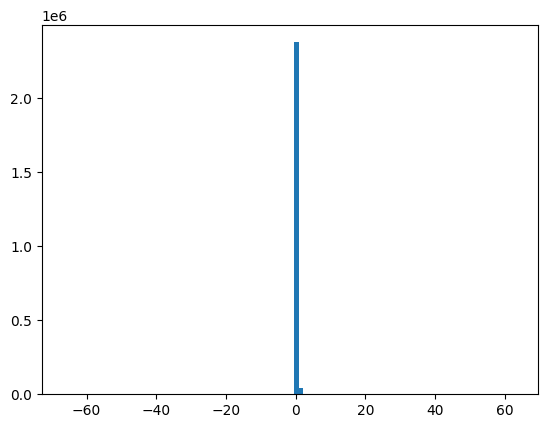

In [42]:
plt.hist(under_120["frequency/duration"], bins=100)